In [1]:
import ccxt
import pandas as pd
import datetime
from tqdm import tqdm

# ターゲットの取引所を指定
TARGET_EXCHANGE = 'ftx'

pd.options.display.min_rows = 30
pd.options.display.max_rows = 100

# ターゲットの取引所を初期化
ccxt_exchange = getattr(ccxt, TARGET_EXCHANGE)()
ccxt_exchange.load_markets()

# Funding Rateの値を入れるデータフレーム
df_fr = pd.DataFrame()

# スポット取引可能な銘柄を入れるリスト
array_spot = []

# 全銘柄について直近のFunding Rate変化を入れたデータフレームを生成
for k, v in tqdm(ccxt_exchange.markets.items()):
    # スポット銘柄はスポット銘柄リストに追加
    if v['type'] == 'spot':
        array_spot.append(k)
        continue
    # スワップ銘柄でなければスキップ
    if v['type'] != 'swap':
        continue
    
    try:
        # CCXTの関数を利用して直近のFunding Rateの履歴をハッシュとして取得
        funding_rate_info_array = ccxt_exchange.fetchFundingRateHistory(k)
        
        # ハッシュからデータフレームを作成。長さが0なら次の銘柄へ
        df_temp = pd.DataFrame(funding_rate_info_array)
        if len(df_temp) == 0:
            continue
        
        # 必要ない列を削除する
        df_temp.drop(['info', 'datetime', 'symbol'], axis=1, inplace=True)
        
        # 列名を変更する
        df_temp.columns = [k.replace(':USD', ''), 'timestamp']

        # ミリ秒単位の時間をtimestampから切り捨て
        df_temp['timestamp'] = df_temp['timestamp'] // 1000
        
        # TimestampからDatetimeを生成してインデックスにし、Timestampは削除
        df_temp['datetime'] = pd.to_datetime(df_temp['timestamp'], unit='s')
        df_temp.drop(['timestamp'], axis=1, inplace=True)
        df_temp.set_index('datetime', inplace=True)
        
        # これまでの計算結果と結合する
        df_fr = pd.concat([df_fr, df_temp], axis=1).fillna(0)
    except:
        print(f'{k} exception occured')
        pass

100%|██████████| 789/789 [00:18<00:00, 42.89it/s]


In [2]:
df_describe = df_fr.describe()
df_describe_t = df_describe.T

df_describe_t['APY'] = df_describe_t['mean']*24*365*100
df_describe_t['APY_std'] = df_describe_t['std']*24*365*100

df_describe_t['APY_diff'] = df_describe_t['APY'] - df_describe_t['APY_std']
df_describe_t_positives = df_describe_t[(df_describe_t['APY_diff'] > 0) & (df_describe_t['APY'] > 0)].copy()
df_describe_t_positives.sort_values('APY_diff', inplace=True)

pd.options.display.min_rows = 10
pd.options.display.max_rows = 30
display(df_describe_t_positives)

,count,mean,std,min,25%,50%,75%,max,APY,APY_std,APY_diff
HNT/USD,500.0,0.000023,0.000023,-0.000130,0.000010,0.000023,0.000038,0.000099,20.571984,20.216496,0.355488
GRT/USD,500.0,0.000013,0.000011,-0.000033,0.000006,0.000012,0.000021,0.000044,11.303904,10.070537,1.233367
CELO/USD,500.0,0.000024,0.000017,-0.000068,0.000013,0.000023,0.000035,0.000080,20.797992,14.930608,5.867384
TONCOIN/USD,500.0,0.000024,0.000016,-0.000015,0.000012,0.000022,0.000034,0.000077,21.029256,13.657402,7.371854
TRU/USD,500.0,0.000025,0.000014,-0.000018,0.000017,0.000026,0.000034,0.000061,22.218864,12.613736,9.605128
AMPL/USD,500.0,0.000492,0.000404,-0.000721,0.000214,0.000490,0.000672,0.002540,431.161944,353.762332,77.399612


<AxesSubplot:xlabel='datetime'>

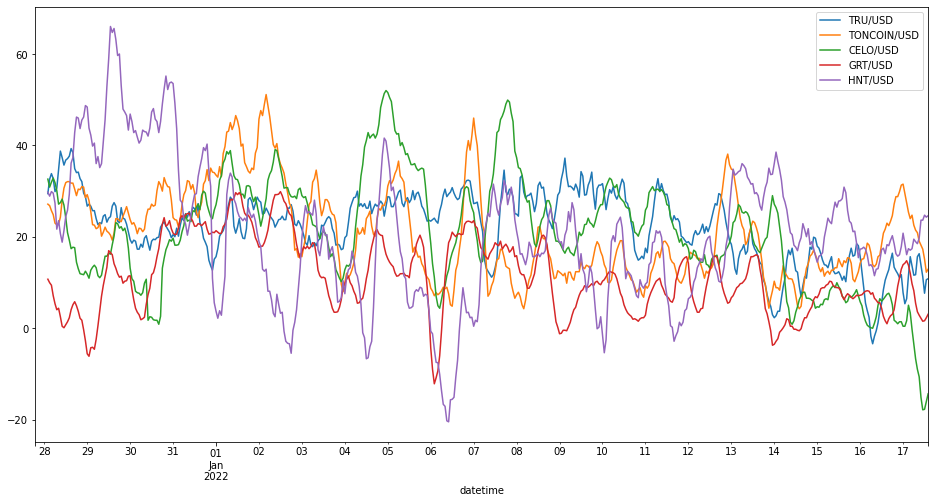

In [3]:
from matplotlib import pyplot

(df_fr[['TRU/USD', 'TONCOIN/USD', 'CELO/USD', 'GRT/USD', 'HNT/USD']].rolling(8).mean()*24*365*100).plot(label='FR', figsize=(16, 8))

<AxesSubplot:xlabel='datetime'>

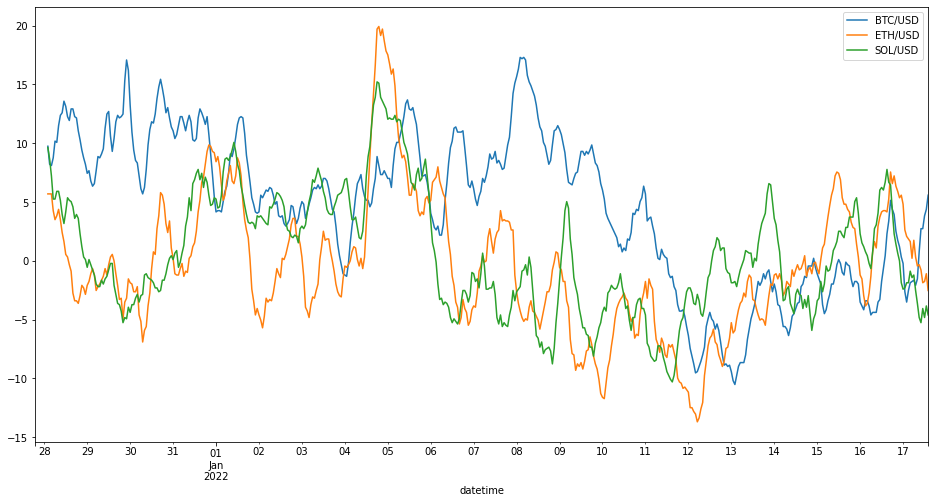

In [4]:
(df_fr[['BTC/USD', 'ETH/USD', 'SOL/USD']].rolling(8).mean()*24*365*100).plot(label='FR', figsize=(16, 8))